# analysis
Analyzing each type of quantum among exponential, uniform, and constant

In [117]:
from glob import glob
import sys, os
import matplotlib.pyplot as plt
import pickle
import numpy as np
import desutils
from functools import reduce
from matplotlib.lines import Line2D
from bltools import letter_subplots

In [2]:
cpu3    = "batchInteractive_3cpu/"
cpu1    = "batchInteractive_1cpu/"
rl_cpu1 = "batchInteractive_1cpu_rl/"
rl_cpu3 = 'batchInteractive_3cpu_rl/'

In [3]:
cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu1, '*')))))
cpu3_qs   = sorted(list(filter(os.path.isdir, glob(os.path.join(cpu3, '*')))))
rl_cpu1_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu1, '*')))))
rl_cpu3_qs = sorted(list(filter(os.path.isdir, glob(os.path.join(rl_cpu3, '*')))))

- (average) number of processes completed per quantum
- (average) throughput per process

In [56]:
def get_pickle(filename):
    with open(filename, 'rb') as pk:
        return pickle.load(pk)
    
def get_sims(quantum_dir):
    sims = sorted(glob(os.path.join(quantum_dir, "pickles/*")))
    print(f"\r{80*' '}\r{quantum_dir}", end='',flush=True)
    return [get_pickle(simfile) for simfile in sims]

def cache_handle(handler):
    """
    decorator to do arbitrary pickle caching
    args:
        :handler (function) - returns the data if it is not cached
        args:
            :pkf (str) - path to check for caching
            :*args - the arguments that handler takes
        returns:
            :the object that will be pickled at pkf
    """
    def wrapper(pkf, *args):
        if not isinstance(pkf, str):
            raise ValueError
        try:
            with open(pkf,'rb') as pk:
                print(f"{pkf} is cached!")
                return pickle.load(pk)
        except FileNotFoundError:
            o = handler(*args)
            with open(pkf,'wb') as pk:
                pickle.dump(o,pk)
                print(f"cached content to {pkf}")
            return o
    return wrapper

@cache_handle
def param_per_t(q, param):
    return [param_per_t_(get_sims(qdir), param) for qdir in q]

def param_per_t_(sims, param):
    aggregator = dict()
    ptypes = sims[0].factory.process_types
    for sim in sims:
        for t in sim.time_parameterized_process_stats:
            t_proc_stats = sim.time_parameterized_process_stats[t]
            for ptype in ptypes:
                try:
                    if isinstance(t_proc_stats[ptype][param], int):
                        aggregator[t][ptype].append(t_proc_stats[ptype][param])
                    else:
                        aggregator[t][ptype].extend(t_proc_stats[ptype][param])

                except KeyError:
                    aggregator[t] = {ptype:[] for ptype in ptypes}

                    if isinstance(t_proc_stats[ptype][param], int):
                        aggregator[t][ptype].append(t_proc_stats[ptype][param])
                    else:
                        aggregator[t][ptype].extend(t_proc_stats[ptype][param])
    for t in aggregator:
        for ptype in ptypes:
            if aggregator[t][ptype]:
                #print(aggregator[t][ptype])
                aggregator[t][ptype] = np.mean(aggregator[t][ptype])
            else:
                aggregator[t][ptype] = None
    return aggregator, ptypes

def per_process_param_per_t(ppt, ptypes, avg=False):
    if avg:
        time = []
        param = []
        for t in ppt:
            if any(ppt[t][ptype] for ptype in ptypes):
                time.append(t)
                param.append(np.mean([ppt[t][ptype] for ptype in ptypes if ppt[t][ptype]]))
        return time, param

    ptype2time_param = {ptype:[[],[]] for ptype in ptypes}
    for t in ppt:
        for ptype in ptypes:
            if ppt[t][ptype]:
                ptype2time_param[ptype][0].append(t)
                ptype2time_param[ptype][1].append(ppt[t][ptype])
                
    for ptype in ptypes:
        ptype2time_param[ptype][0] = sorted(ptype2time_param[ptype][0])
        ptype2time_param[ptype][1] = [ppt[t][ptype] for t in ptype2time_param[ptype][0]]
    return ptype2time_param

def rl_throughput(tp):        
    ptype2tp = dict()
    for ptype in tp: 
        cum_sum = 0
        Ts = []
        throughput_vals = []
        for t, nprocs_completed in sorted(tp[ptype].items(), key=lambda it:it[0]):
            #print(nprocs_completed)
            mean, std = nprocs_completed
            cum_sum += mean
            thp = cum_sum/t
            Ts.append(t)
            throughput_vals.append(thp)
        ptype2tp[ptype] = [Ts, throughput_vals]
    return ptype2tp

def avg_throughput(sims):
    ptypes = sims[0].factory.process_types
    #for sim in sims:
    #    sim.finalize()
    
    ptype2throughputs = {ptype:dict() for ptype in ptypes}
    for ptype in ptypes:
        ptype_tp = dict()
        for sim in sims:
            for t in sim.process_stats[ptype]['throughput']:
                try:
                    ptype_tp[t].append(sim.process_stats[ptype]['throughput'][t])
                except KeyError:
                    ptype_tp[t] = [sim.process_stats[ptype]['throughput'][t]]
        for t in ptype_tp:
            ptype2throughputs[ptype][t] = (np.mean(ptype_tp[t]), np.std(ptype_tp[t]))
    return ptype2throughputs

@cache_handle
def throughput(q):
    return [avg_throughput(get_sims(qdir)) for qdir in q]

def avg_final_n(param, n=1000, **kwargs):
    return np.mean(param[-n:])
   
def join(prefix,suffix):
    return os.path.join(prefix, suffix)

def avg_procs_completed(sims):
    """
    compute the (average across each simulation) number
    of processes completed for this quantum
    """
    procs_completed = [des.processes_completed for des in sims]
    return np.mean(procs_completed), np.std(procs_completed)

@cache_handle
def procs_completed(q):
    return [avg_procs_completed(get_sims(qdir)) for qdir in q]

const_qs = [0, 1] + list(range(10,201,5))

In [7]:
wait_time_per_t_per_q_cpu1 = param_per_t(os.path.join(cpu1, 'wt_per_t.bin'),cpu1_qs, 'wait_time')
wait_time_per_t_per_q_cpu3 = param_per_t(os.path.join(cpu3, 'wt_per_t.bin'),cpu3_qs, 'wait_time')
wait_time_per_t_per_q_cpu3_rl = param_per_t(os.path.join(rl_cpu3, 'wt_per_t.bin'),rl_cpu3_qs, 'wait_time')
wait_time_per_t_per_q_cpu1_rl = param_per_t(os.path.join(rl_cpu1, 'wt_per_t.bin'),rl_cpu1_qs, 'wait_time')


turnaround_per_t_per_q_cpu1 = param_per_t(os.path.join(cpu1, 'turnaround.bin'),cpu1_qs, 'turnaround')
turnaround_per_t_per_q_cpu3 = param_per_t(os.path.join(cpu3, 'turnaround.bin'),cpu3_qs, 'turnaround')
turnaround_per_t_per_q_cpu3_rl = param_per_t(os.path.join(rl_cpu3, 'turnaround.bin'),rl_cpu3_qs, 'turnaround')
turnaround_per_t_per_q_cpu1_rl = param_per_t(os.path.join(rl_cpu1, 'turnaround.bin'),rl_cpu1_qs, 'turnaround')

preempt_per_t_per_q_cpu1 = param_per_t(os.path.join(cpu1, 'preemptions.bin'),cpu1_qs, 'preemptions')
preempt_per_t_per_q_cpu3 = param_per_t(os.path.join(cpu3, 'preemptions.bin'),cpu3_qs, 'preemptions')
preempt_per_t_per_q_cpu3_rl = param_per_t(os.path.join(rl_cpu3, 'preemptions.bin'),rl_cpu3_qs, 'preemptions')
preempt_per_t_per_q_cpu1_rl = param_per_t(os.path.join(rl_cpu1, 'preemptions.bin'),rl_cpu1_qs, 'preemptions')

batchInteractive_1cpu/wt_per_t.bin is cached!
batchInteractive_3cpu/wt_per_t.bin is cached!
batchInteractive_3cpu_rl/wt_per_t.bin is cached!
batchInteractive_1cpu_rl/wt_per_t.bin is cached!
batchInteractive_1cpu/turnaround.bin is cached!
batchInteractive_3cpu/turnaround.bin is cached!
batchInteractive_3cpu_rl/turnaround.bin is cached!
batchInteractive_1cpu_rl/turnaround.bin is cached!
batchInteractive_1cpu/preemptions.bin is cached!
batchInteractive_3cpu/DESQuantum__0200                                          cached content to batchInteractive_3cpu/preemptions.bin
batchInteractive_3cpu_rl/DES_RL                                                 cached content to batchInteractive_3cpu_rl/preemptions.bin
batchInteractive_1cpu_rl/DES_RL                                                 cached content to batchInteractive_1cpu_rl/preemptions.bin


In [11]:
def avgs(pptpq):
    avgs = []
    for i, (ppt, ptypes) in enumerate(pptpq):
        print(f"\r{80 * ' '}\r{i}/{len(pptpq)}", end='', flush=True)
        time1, const_wt = per_process_param_per_t(ppt, ptypes,avg=True)
        avgs.append(avg_final_n(const_wt))
    return avgs

avgs_wt_cpu1 = avgs(wait_time_per_t_per_q_cpu1)
avgs_wt_cpu3 = avgs(wait_time_per_t_per_q_cpu3)
avgs_wt_cpu1_rl = avgs(wait_time_per_t_per_q_cpu1_rl)
avgs_wt_cpu3_rl = avgs(wait_time_per_t_per_q_cpu3_rl)

0/1                                                                             

In [22]:
avgs_tu_cpu1 = avgs(turnaround_per_t_per_q_cpu1)
avgs_tu_cpu3 = avgs(turnaround_per_t_per_q_cpu3)
avgs_tu_cpu1_rl = avgs(turnaround_per_t_per_q_cpu1_rl)
avgs_tu_cpu3_rl = avgs(turnaround_per_t_per_q_cpu3_rl)

0/1                                                                             

In [51]:
avgs_pr_cpu1 = avgs(preempt_per_t_per_q_cpu1)
avgs_pr_cpu3 = avgs(preempt_per_t_per_q_cpu3)
avgs_pr_cpu1_rl = avgs(preempt_per_t_per_q_cpu1_rl)
avgs_pr_cpu3_rl = avgs(preempt_per_t_per_q_cpu3_rl)

1/41                                                                            

/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0/1                                                                             

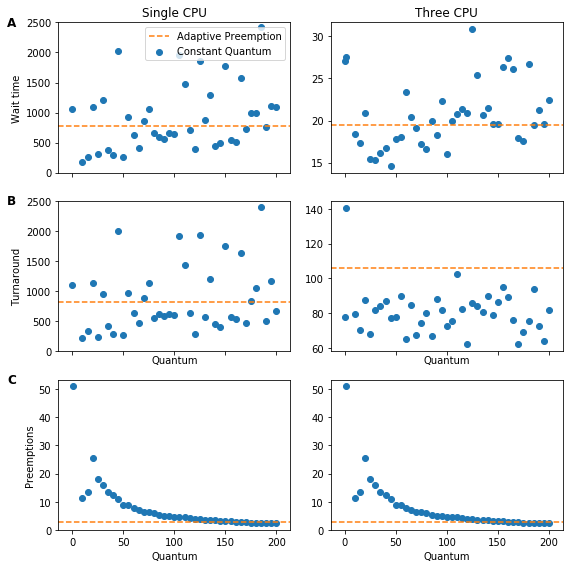

In [131]:
fig, axarr = plt.subplots(3,2, sharex=True, figsize=(8,8))
axarr[0][0].set_ylim(0,2500)
axarr[1][0].set_ylim(0,2500)
axarr[0][0].scatter(const_qs, avgs_wt_cpu1,label='Constant Quantum' )
axarr[0][0].axhline(avgs_wt_cpu1_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")
axarr[1][0].scatter(const_qs, avgs_tu_cpu1)
axarr[1][0].axhline(avgs_tu_cpu1_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")

axarr[0][1].scatter(const_qs, avgs_wt_cpu3,label='Constant Quantum' )
axarr[0][1].axhline(avgs_wt_cpu3_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")
axarr[1][1].scatter(const_qs, avgs_tu_cpu3,label='Constant Quantum' )
axarr[1][1].axhline(avgs_tu_cpu3_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")

axarr[2][0].scatter(const_qs, avgs_pr_cpu3,label='Constant Quantum' )
axarr[2][0].axhline(avgs_pr_cpu3_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")
axarr[2][1].scatter(const_qs, avgs_pr_cpu3,label='Constant Quantum' )
axarr[2][1].axhline(avgs_pr_cpu3_rl[0], linestyle='--', color='C1', label="Adaptive Preemption")

axarr[0][0].legend(frameon=True)
axarr[1][1].set_xlabel("Quantum")
axarr[1][0].set_xlabel("Quantum")
axarr[2][0].set_xlabel("Quantum")
axarr[2][1].set_xlabel("Quantum")


axarr[0][0].set_title("Single CPU")
axarr[0][1].set_title("Three CPU")
axarr[0][0].set_ylabel("Wait time")
axarr[1][0].set_ylabel("Turnaround")
axarr[2][0].set_ylabel("Preemptions")
letter_subplots(axes=[ax[0] for ax in axarr], xoffset=[-0.2,-0.2,-0.2])
plt.tight_layout()
plt.savefig('figs/params_per_q.pdf')
plt.show()

In [71]:
cpu1_procs_comp = procs_completed(os.path.join(cpu1, 'completed.bin'), cpu1_qs)
cpu3_procs_comp= procs_completed(os.path.join(cpu3, 'completed.bin'), cpu3_qs)
rl_cpu1_procs_comp = procs_completed(os.path.join(rl_cpu1, 'completed.bin'), rl_cpu1_qs)
rl_cpu3_procs_comp = procs_completed(os.path.join(rl_cpu3, 'completed.bin'), rl_cpu3_qs)

batchInteractive_1cpu/completed.bin is cached!
batchInteractive_3cpu/DESQuantum__0200                                          cached content to batchInteractive_3cpu/completed.bin
batchInteractive_1cpu_rl/completed.bin is cached!
batchInteractive_3cpu_rl/completed.bin is cached!


In [78]:
def plot_procs_completed(procs_comp, ax, color="C0", **kwargs):
    procs_comp_m, procs_comp_s = map(np.array, zip(*procs_comp))
    ci = procs_comp_s*1.96
    ax.fill_between(const_qs, procs_comp_m + ci, procs_comp_m - ci,alpha=0.15,color=color)
    ax.scatter(const_qs, procs_comp_m,color=color, **kwargs)

In [114]:
@cache_handle
def max_throughput(exp_class):
    """
    find the throughput per time trend for the
    top quantum in the experiment class
    (i.e, constant Q=25, 3 cpus)
    """
    top_procs_completed = 0
    top_class_idx = None
    top_class = None
    for i, cls in enumerate(exp_class):
        avg_procs_completed = 0
        num_sims = 0
        for sim in get_sims(cls):
            avg_procs_completed += sim.processes_completed
            num_sims += 1
    
        avg_procs_completed /= num_sims
        if avg_procs_completed > top_procs_completed:
            top_class = cls
            top_class_idx = i
            top_procs_completed = avg_procs_completed

    return _throughput(get_sims(exp_class[top_class_idx])), top_class

def _throughput(simulation_collection):
    ptypes = simulation_collection[0].factory.process_types
    ptype2throughputs = {ptype:dict() for ptype in ptypes}

    ptype_tp = dict()
    for sim in simulation_collection:
        for ptype in ptypes:
            for t in sim.process_stats[ptype]['throughput']:
                try:
                    ptype_tp[t].append(sim.process_stats[ptype]['throughput'][t])
                except KeyError:
                    ptype_tp[t] = [sim.process_stats[ptype]['throughput'][t]]
                    
    for ptype in ptype2throughputs:
        for t in ptype_tp:
            ptype2throughputs[ptype][t] = (np.mean(ptype_tp[t]), np.std(ptype_tp[t]))
    return ptype2throughputs

In [154]:
max_tp_cpu1    = max_throughput(os.path.join(cpu1, 'max_throughput.bin'),cpu1_qs)
max_tp_cpu3    = max_throughput(os.path.join(cpu3, 'max_throughput.bin'),cpu3_qs)
max_tp_cpu1_rl = max_throughput(os.path.join(rl_cpu1, 'max_throughput.bin'),rl_cpu1_qs)
max_tp_cpu3_rl = max_throughput(os.path.join(rl_cpu3, 'max_throughput.bin'),rl_cpu3_qs)

batchInteractive_1cpu/max_throughput.bin is cached!
batchInteractive_3cpu/max_throughput.bin is cached!
batchInteractive_1cpu_rl/max_throughput.bin is cached!
batchInteractive_3cpu_rl/max_throughput.bin is cached!


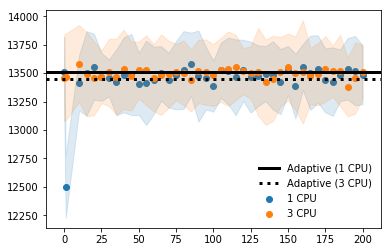

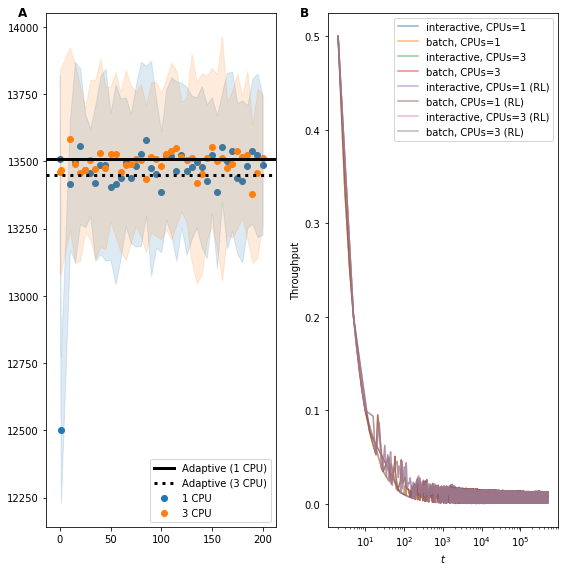

In [165]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,8))
def plot_tp(max_tp, ax, ncpu):
    ncpu = str(ncpu)
    d, q = max_tp
    for ptype in d:
        ts = sorted(list(d[ptype].keys()))
        vals = [d[ptype][t][0] for t in ts]
        plt.plot(ts,vals,label=ptype + f", CPUs={ncpu}",alpha=0.55)

plt.xscale('log')
plot_tp(max_tp_cpu1,ax2,1)
plot_tp(max_tp_cpu3,ax2,3)
plot_tp(max_tp_cpu1_rl,ax2,"1 (RL)")
plot_tp(max_tp_cpu3_rl,ax2,"3 (RL)")
plt.ylabel("Throughput")
plt.xlabel("$t$")

plot_procs_completed(cpu1_procs_comp, ax1, label="1 CPU")
plot_procs_completed(cpu3_procs_comp, ax1, color="C1", label="3 CPU")
ax1.axhline(rl_cpu1_procs_comp[0][0], color="k", label="Adaptive (1 CPU)", linestyle='-', linewidth=3.)
ax1.axhline(rl_cpu3_procs_comp[0][0], color="k", label="Adaptive (3 CPU)", linestyle=':',linewidth=3.)
letter_subplots(axes=(ax1,ax2))
ax1.legend(loc='lower right',frameon=True)
ax2.legend(frameon=True)
plt.tight_layout()
plt.savefig('figs/procs_completed.pdf')
plt.show()